In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
srcdir = parentdir + '/src/lmpc/'
os.sys.path.insert(1, srcdir)

import numpy as np
from quadprog import solve_qp
import matplotlib.patches as patches
import reference_trajectories, cost_function, constraints, motionModel, plot_utils 

In [2]:
#    LMPC_walking is a python software implementation of one of the algorithms
#    refered in this paper https://hal.inria.fr/inria-00391408v2/document
#    Copyright (C) 2019 @ahmad gazar

#    LMPC_walking is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.

#    LMPC_walking is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.

#    You should have received a copy of the GNU General Public License
#    along with this program.  If not, see <https://www.gnu.org/licenses/>.

# regularization terms in the cost function:
# -----------------------------------------
alpha = 10**(-6)     # jerk cost weight
gamma = 10**(1)   # CoP error cost weight

# regularization term for Q
Q_reg = 0*10**(-10)

# CoM initial state: [x, xdot, x_ddot].T
#                    [y, ydot, y_ddot].T
# --------------------------------------
x_hat_0 = np.array([0.0, 0.0, 0.0])
y_hat_0 = np.array([-0.096, 0.0, 0.0])

# Inverted pendulum parameters:
# ----------------------------
h           = 0.61 # fixed height of the CoM assuming walking on a flat terrain
g           = 9.81  # norm of the gravity acceleration vector
foot_length = 0.217
foot_width  = 0.138

# MPC parameters:
# --------------
T                = 0.001                        # sampling time interval
step_time        = .8                        # step duration
no_steps_per_T   = int(round(step_time/T))

# walking parameters:
# ------------------
Step_length      = 0.2                       # fixed step length in the xz-plane
no_steps         = 10                         # number of desired walking steps
walking_time     = no_steps * no_steps_per_T  # number of desired walking intervals

# compute CoP reference trajectory:
# --------------------------------
foot_step_0 = np.array([0.0, -0.096])         # initial foot step position in x-y
Foot_steps  = reference_trajectories.manual_foot_placement(foot_step_0, Step_length, no_steps)
Z_ref       = reference_trajectories.create_CoP_trajectory(no_steps, Foot_steps, \
                                                      walking_time, no_steps_per_T)


# used in case you want to have terminal constraints
# -------------------------------------------------
# x_terminal = np.array([Z_ref[walking_time-1, 0], 0.0, 0.0])  # CoM final constraint in x : [x, xdot, x_ddot].T
# y_terminal = np.array([Z_ref[walking_time-1, 1], 0.0, 0.0])  # CoM final constraint in y : [y, ydot, y_ddot].T
# no_terminal_constraints = 6
# terminal_index = walking_time-1

# construct your preview system: 'Go pokemon !'
# --------------------------------------------
[P_ps, P_vs, P_as, P_zs, P_pu, P_vu, P_au, P_zu] = motionModel.compute_recursive_matrices(walking_time, T, h, g)
[Q, p_k] = cost_function.compute_objective_terms(alpha, gamma, walking_time, \
                                            P_zs, P_zu, x_hat_0, y_hat_0, Z_ref)
[A_zmp, b_zmp]   = constraints.add_ZMP_constraints(walking_time, foot_length, foot_width,\
                                          P_zs, P_zu, Z_ref, x_hat_0, y_hat_0)

# uncomment in case you want to add both terminal add_ZMP_constraints
# -------------------------------------------------------------------
#[A_terminal, b_terminal] = constraints.add_terminal_constraints(walking_time,\
#                            terminal_index, x_hat_0, y_hat_0, x_terminal, \
#                             y_terminal, P_ps, P_vs, P_as, P_pu, P_vu, P_au)

#A = np.concatenate((A_terminal, A_zmp), axis = 0)
#b = np.concatenate((b_terminal, b_zmp), axis = 0)

Q = Q_reg*np.identity(2*walking_time) + Q   #making sure that Q is +ve definite

# call quadprog solver:
# --------------------
#U = solve_qp(Q, -p_k, A.T, b, no_terminal_constraints)[0]  # solve with 6 equality terminal constraints
U = solve_qp(Q, -p_k, A_zmp.T, b_zmp)[0]                    # solve only with CoP inequality constraints

# Trahjectory optimization: (based on the initial state x_hat_0, y_hat_0)
# -------------------------------------------------------------------------
[X, Y, Z_x, Z_y] = motionModel.compute_recursive_dynamics(P_ps, P_vs, P_as, \
                                                          P_zs, P_pu, P_vu, \
                                                          P_au, P_zu, \
                                                          walking_time, \
                                                          x_hat_0, y_hat_0, U)
# ------------------------------------------------------------------------------
# debugging:
# ------------------------------------------------------------------------------
# create a dictionary for data logging
traj_data = {}
traj_data['zmp_reference'] = Z_ref
traj_data['X']   = X
traj_data['Y']   = Y
traj_data['Z_x'] = Z_x
traj_data['Z_y'] = Z_y

In [3]:
Z = np.zeros((X.shape))
Z[:, 0] = h - 0.855
Com = np.stack((X,Y,Z), axis=2)
np.save(parentdir + '/data/com', Com )
np.save(parentdir + '/data/foot_steps', Foot_steps )

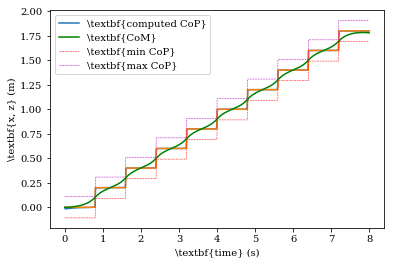

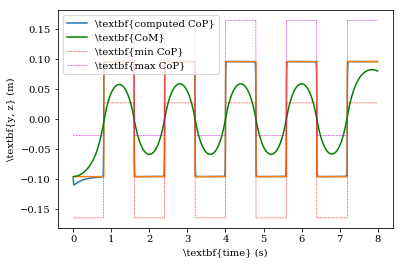

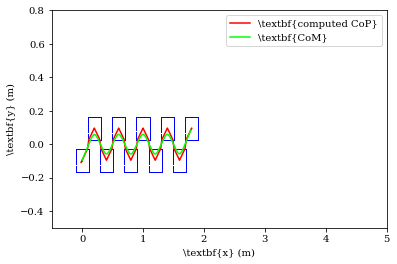

In [4]:
# ------------------------------------------------------------------------------
# visualize:
# ------------------------------------------------------------------------------
Time               = np.arange(0, round(walking_time*T, 2), T)
min_admissible_CoP = Z_ref - np.tile([foot_length/2, foot_width/2], (walking_time,1))
max_admissible_cop = Z_ref + np.tile([foot_length/2, foot_width/2], (walking_time,1))

# time vs CoP and CoM in x-direction (forward): 'A.K.A run rabbit run !'
# -------------------------------------------------
plot_utils.plot_x(Time, walking_time, min_admissible_CoP, max_admissible_cop, \
                  Z_x, X, Z_ref)

# time VS CoP and CoM in y-direction (lateral): 'A.K.A what goes up must go down'
# ----------------------------------------------------------
plot_utils.plot_y(Time, walking_time, min_admissible_CoP, max_admissible_cop, \
                  Z_y, Y, Z_ref)

# plot CoP, CoM in x Vs Cop, CoM in y:
# -----------------------------------
plot_utils.plot_xy(Time, walking_time, foot_length, foot_width, Z_ref, \
                   Z_x, Z_y, X, Y)